In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda, Input, Dense, Layer, Concatenate
from tensorflow.keras.models import Model
import random as rn
import numpy as np
import tensorflow as tf

rn.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim), seed=123)
    
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

NUM_CLASSES = y_train_one_hot.shape[1]

In [33]:
X_input = Input(shape=(x_train.shape[1],)) 
cond = Input(shape=(NUM_CLASSES,))

inputs = Concatenate()([X_input, cond])

encoder_h = Dense(intermediate_dim, activation='relu')(inputs)
mu = Dense(latent_dim, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(latent_dim, activation='linear')(encoder_h)

z = Lambda(sampling, output_shape = (latent_dim, ))([mu, l_sigma])

zc = Concatenate(name='z_condition')([z, cond])

decoder_hidden = Dense(intermediate_dim, activation='relu', name='decoder_hidden')
decoder_output = Dense(original_dim, activation='sigmoid', name='decoder_output')

decoder_intermediate = decoder_hidden(zc)
decoder_output_layer = decoder_output(decoder_intermediate)

cvae = Model([X_input, cond], [decoder_output_layer,mu, l_sigma])
encoder = Model(cvae.inputs, cvae.get_layer('mu').output)


decoder_z = Input(shape=(latent_dim,))
decoder_cond = Input(shape=(NUM_CLASSES,))

decoder_input = Concatenate()([decoder_z, decoder_cond])

slice_decoder_hidden = decoder_hidden(decoder_input)
slice_decoder_output = decoder_output(slice_decoder_hidden)
decoder = Model([decoder_z, decoder_cond], slice_decoder_output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

epochs = 50

for epoch in range(epochs):
    
    loss_metric = tf.keras.metrics.Mean()
    
    for x_batch_train, y_batch_train in train_dataset:
        
        with tf.GradientTape() as tape:
            
            reconstructed, z_mu, z_sigma = cvae((x_batch_train, y_batch_train))
            
            mse_loss = mse_loss_fn(x_batch_train, reconstructed)
            mse_loss *= original_dim

            kl_loss = -0.5 * tf.reduce_sum(1 + z_sigma - tf.square(z_mu) - tf.exp(z_sigma), axis=-1)
            
            loss = tf.reduce_mean(mse_loss + kl_loss)

        grads = tape.gradient(loss, cvae.trainable_weights)
        optimizer.apply_gradients(zip(grads, cvae.trainable_weights))

        loss_metric(loss)

    if not epoch % 10:
        
        print('Epoch %s: mean loss = %s' % (epoch, loss_metric.result()))

Epoch 0: mean loss = tf.Tensor(45.557636, shape=(), dtype=float32)
Epoch 10: mean loss = tf.Tensor(31.216755, shape=(), dtype=float32)
Epoch 20: mean loss = tf.Tensor(30.419346, shape=(), dtype=float32)
Epoch 30: mean loss = tf.Tensor(30.066004, shape=(), dtype=float32)
Epoch 40: mean loss = tf.Tensor(29.864248, shape=(), dtype=float32)


In [34]:
z_mean_test = encoder((x_test, y_test_one_hot))

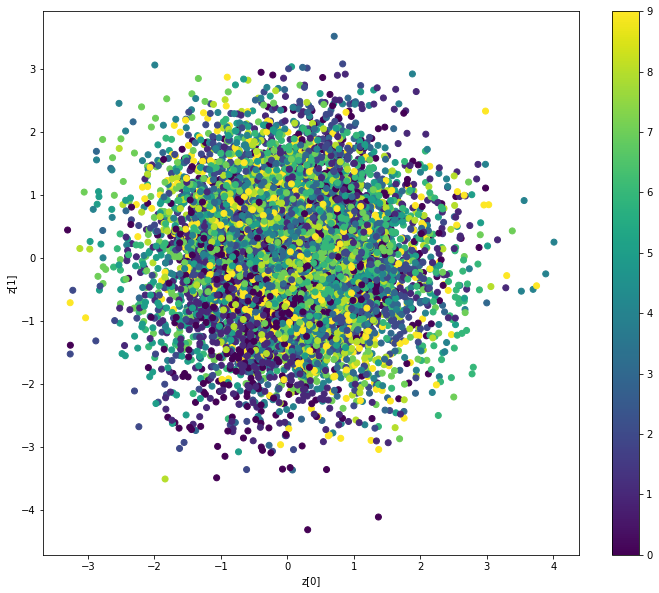

In [35]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean_test[:, 0], z_mean_test[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [12]:
# n = 30
# digit_size = 28
# figure = np.zeros((digit_size * n, digit_size * n))
# # linearly spaced coordinates corresponding to the 2D plot
# # of digit classes in the latent space
# grid_x = np.linspace(-4, 4, n)
# grid_y = np.linspace(-4, 4, n)[::-1]

# for i, yi in enumerate(grid_y):
#     for j, xi in enumerate(grid_x):
#         z_sample = np.array([[xi, yi]])
#         x_decoded = decoder.predict(z_sample)
#         digit = x_decoded[0].reshape(digit_size, digit_size)
#         figure[i * digit_size: (i + 1) * digit_size,
#                j * digit_size: (j + 1) * digit_size] = digit

# plt.figure(figsize=(10, 10))
# start_range = digit_size // 2
# end_range = (n - 1) * digit_size + start_range + 1
# pixel_range = np.arange(start_range, end_range, digit_size)
# sample_range_x = np.round(grid_x, 1)
# sample_range_y = np.round(grid_y, 1)
# plt.xticks(pixel_range, sample_range_x)
# plt.yticks(pixel_range, sample_range_y)
# plt.xlabel("z[0]")
# plt.ylabel("z[1]")
# plt.imshow(figure, cmap='Greys_r')
# plt.show()

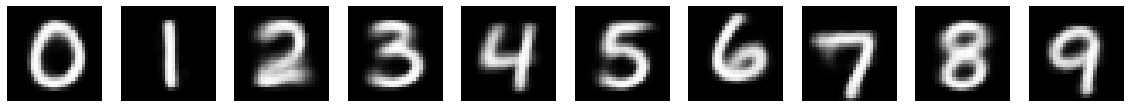

In [72]:
digit_size = 28

z_sample = np.random.rand(1, 2)

plt.figure(figsize=(20, 2))

for i in range(10):
    
    c = tf.keras.utils.to_categorical(i,NUM_CLASSES)
    
    c = c.reshape(1,-1)
    x_decoded = decoder.predict([z_sample, c])
    digit = x_decoded[0].reshape(digit_size, digit_size)

    plt.subplot(1, NUM_CLASSES, i+1)
    plt.axis('off')
    plt.imshow(digit, cmap='Greys_r')
plt.show()